## Codice usando i dati presenti nel  [paper(pag 18, paragrafo 4.2)](https://drive.google.com/file/d/1YBFS7FW81_pyuryAb5ISiofgLkT7Gp-P/view?usp=sharing).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../library/')
from utils import *
import numpy as np 
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler
import dimod
import dwave.inspector
import pickle

In [2]:
mu0 = 0.2
var0 = 1

x = np.array([-2.296, -0.216, -0.082, 0.231, 1.127, 1.164, 1.189, 1.236, 1.272, 1.373])

In [3]:
Nodes = [f'a{i}' for i in range(-7, 2)] + [f'b{i}' for i in range(-7, 2)]

C_G = nx.complete_graph(Nodes)

In [4]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

node_bias = []

for i, node in enumerate(C_G.nodes):
    if node[0] == 'a':
        p = int(node[1:])
        w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_bias.append(w)
        bqm.add_variable(v=node, bias=w)
    else:
        p = int(node[1:])
        w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_bias.append(w)
        bqm.add_variable(v=node, bias=w)

(array([ 2.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  3., 11.]),
 array([-38.11778   , -34.31456054, -30.51134109, -26.70812163,
        -22.90490218, -19.10168272, -15.29846327, -11.49524381,
         -7.69202436,  -3.8888049 ,  -0.08558545]),
 <BarContainer object of 10 artists>)

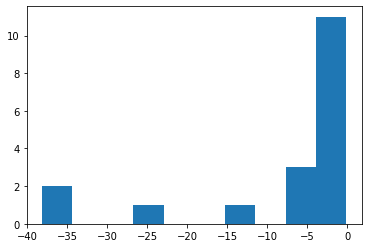

In [5]:
plt.hist(node_bias)

In [6]:
A = []
B = []
AB = []

link_A, link_B, link_AB = 0, 0, 0
eps_A = 0
eps_B = 0
eps_AB = 10000

for edge in C_G.edges:
    node1, node2 = edge
    if node1[0] == node2[0] == 'a':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -2**(pi+pj)*fAA(var0)
        
        #w = np.sqrt(w)
        if w > eps_A:
            link_A += 1
            A.append(w)
            bqm.add_interaction(node1, node2, w)
            
    elif node1[0] == node2[0] == 'b':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fBB(x, mu0, var0))
        
        #w = np.sqrt(w)
        if w > eps_B:
            link_B += 1
            B.append(w)
            bqm.add_interaction(node1, node2, w)
            
    else:
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fAB(x, mu0, var0))
        
        #w = np.sqrt(w)
        if w < eps_AB:    
            link_AB += 1
            AB.append(w)
            bqm.add_interaction(node1, node2, w)

In [7]:
np.min(A + B +AB)

0.0001220703125

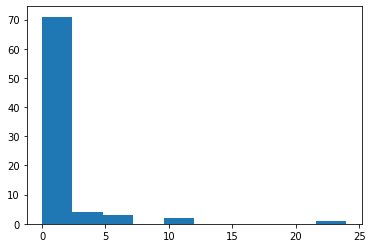

In [8]:
plt.hist(AB, bins=10);

In [9]:
link_A, link_B, link_AB, link_A+link_B+link_AB

(36, 36, 81, 153)

In [10]:
np.sum(-(x-mu0)**2/(var0)**2)

-12.848712000000003

In [11]:
sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=10000) #chain_strenght=5

In [14]:
mu, var = 0, 0

for key, q in sampleset.first.sample.items():
    p = int(key[1:])
    if key[0] == 'a':
        mu += 2**(p) * q
    else:
        var += 2**(p) * q
        
mu, var

(0.484375, 1.421875)

In [15]:
lowest_state = sampleset.lowest().record[0][0]
mu, var = 0, 0

for i, sol in enumerate(lowest_state):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
mu, var

(0.484375, 1.421875)

In [61]:
theta = []
phi = []
energy = []

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    freq = rec[2]
    energy += [rec[1]] * freq
    
    mu = 0
    var = 0
    for i, sol in enumerate(states):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
    theta += [mu] * freq
    phi += [var] * freq

In [12]:
theta = []
phi = []
energy = []
f = []

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    f += [rec[2]]
    energy += [rec[1]]
    
    mu = 0
    var = 0
    for i, sol in enumerate(states):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
    theta += [mu]
    phi += [var]

Text(0.5, 1.0, 'Istogramma Media ($\\mu$)')

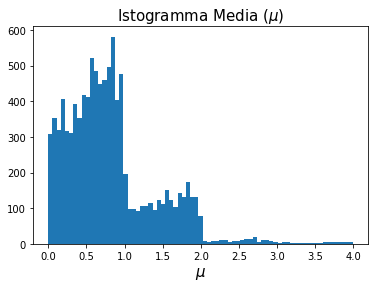

In [62]:
plt.hist(theta, bins='auto');
plt.xlabel('$\mu$', fontdict={'fontsize': 15})
plt.title('Istogramma Media ($\mu$)', fontdict={'fontsize':15})
plt.savefig('media.png')

In [21]:
theta[np.argmax(f)], phi[np.argmax(f)]

(0.5390625, 0.8515625)

<BarContainer object of 9271 artists>

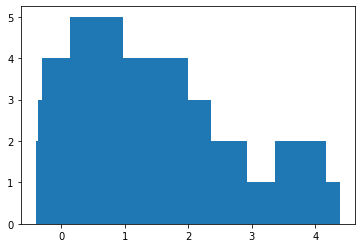

In [13]:
plt.bar(theta, f)

In [64]:
np.mean(theta), np.mean(phi)

(0.80600625, 1.36238984375)

Text(0.5, 1.0, 'Istogramma Varianza ($\\sigma^2$)')

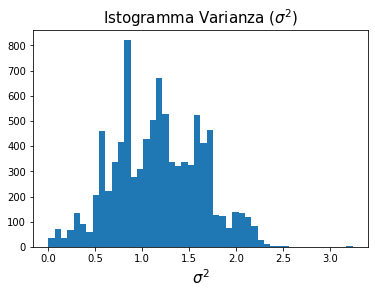

In [17]:
plt.hist(phi, bins='auto')
plt.xlabel('$\sigma^2$', fontdict={'fontsize': 15})
plt.title('Istogramma Varianza ($\sigma^2$)', fontdict={'fontsize':15})
plt.savefig('varianza.png')

Text(0, 0.5, 'Varianza')

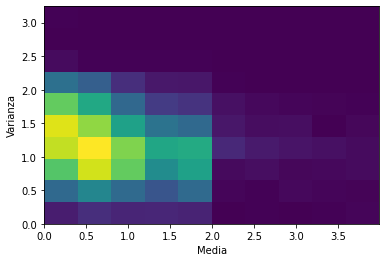

In [18]:
plt.hist2d(theta, phi);
plt.xlabel('Media')
plt.ylabel('Varianza')

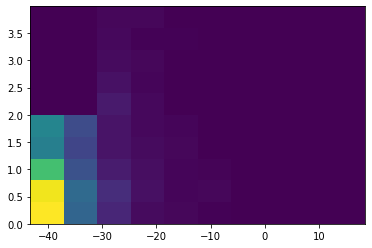

In [19]:
plt.hist2d(energy, theta);

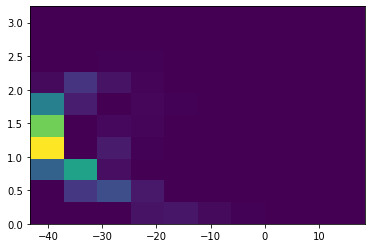

In [20]:
plt.hist2d(energy, phi);

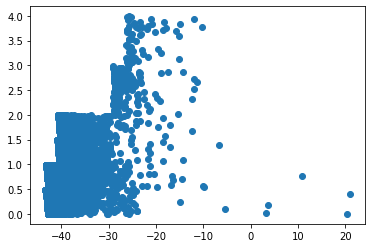

In [69]:
plt.scatter(energy, theta)

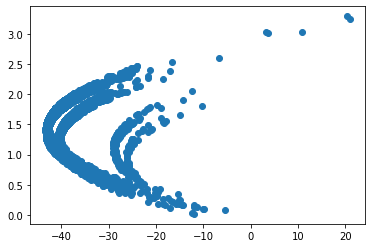

In [70]:
plt.scatter(energy, phi)

In [71]:
dwave.inspector.show(sampleset)

'http://127.0.0.1:18000/?problemId=73271a59-3370-40d0-9d2d-b6d3da9c4e56'